In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
 
import tushare as ts
pro = ts.pro_api('9293b9b01414a95f89aa75f884c907fdc2cd24f41c8ea3de863eaa26')


In [2]:
#复权个股日线

tc = '300015.SZ'
data = ts.pro_bar(api=pro, ts_code=tc, adj='qfq', start_date='20200101', end_date='20201231')
data['trade_date'] = pd.to_datetime(data['trade_date'],format='%Y%m%d')
data.set_index('trade_date', inplace=True)
data = data[::-1].reset_index(drop=True)
data = data.tail(200)

#print(data)
 

In [3]:
def ssa(series, windowLen , pcn  ):
    seriesLen = len(series)
    K = seriesLen - windowLen + 1
    X = np.zeros((windowLen, K))
    for i in range(K):
        X[:, i] = series[i:i + windowLen]
    
    U, sigma, VT = np.linalg.svd(X, full_matrices=False)

    for i in range(VT.shape[0]):
        VT[i, :] *= sigma[i]
    A = VT

    rec = np.zeros((windowLen, seriesLen))
    for i in range(windowLen):
        for j in range(windowLen-1):
            for m in range(j+1):
                rec[i, j] += A[i, j-m] * U[m, i]
            rec[i, j] /= (j+1)
        for j in range(windowLen-1, seriesLen - windowLen + 1):
            for m in range(windowLen):
                rec[i, j] += A[i, j-m] * U[m, i]
            rec[i, j] /= windowLen
        for j in range(seriesLen - windowLen + 1, seriesLen):
            for m in range(j-seriesLen+windowLen, windowLen):
                rec[i, j] += A[i, j - m] * U[m, i]
            rec[i, j] /= (seriesLen - j)
    
    result = np.sum(rec[:pcn], axis=0)
    return result[-1]
    #return result


策略收益率：1.1315880607930997
基准收益率：1.2199288526302077


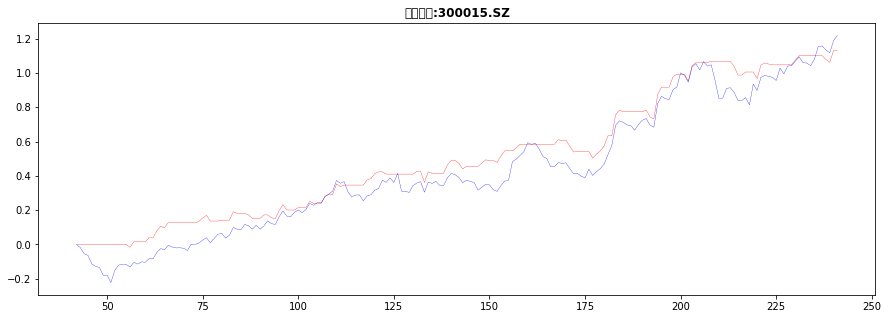

In [4]:

pcn = 1
fwl = 5
swl = 7

#print(series)
#---------------------------------双SSA-------------------------------------------------
data['f_ssa']= data['close'].rolling(2*fwl - 1).apply(ssa,args = (fwl,pcn),raw = True) 
data['s_ssa'] = data['close'].rolling(2*swl - 1).apply(ssa,args = (swl,pcn),raw = True) 
#---------------------------------双SSA导数差-------------------------------------------------
#DataFrame.diff(periods=1, axis=0) ; periods：移动的幅度，int类型，默认值为1;
# axis：移动的方向，{0 or ‘index’, 1 or ‘columns’}，
# 如果为0或者’index’，则上下移动，如果为1或者’columns’，则左右移动。
data['dtf'] =  data['f_ssa']-data['f_ssa'].shift(1)
data['dts'] =  data['s_ssa']-data['s_ssa'].shift(1)
#print(data['dtf'])
#print(data['dts'])
data['ddx'] =  data['dtf'] - data['dts']
#print(data['ddx'])
#---------------------------------回测收益-------------------------------------------------
data['res'] = np.select([data['ddx'] > 0],[data['close']],default = np.nan)  #获取快慢SSA >0的时序
data['attack'] = np.select([data['ddx'] > 0],[1],default = 0)#获取“双SSA斜率差 >0策略”的时序的触发信号
#data['attack'] = np.select([data['f_ssa'] > data['s_ssa']],[1],default = 0)#获取快慢SSA >0的时序的触发信号
#data['attack'] = np.select([data['dtf'] > 0],[1],default = 0)#获取“单SSA >0策略”的时序的触发信号
#print(np.array(data['attack']))

data['buy'] = data['attack'].shift(1) #下移一行买入信号
#print(np.array(data['buy']))

data['base_profit'] = 1+0.01*data['pct_chg'].fillna(0) #计算基准每日收益

data['prod_base_profit'] = data['base_profit'].cumprod()-1 #计算基准每日收益累乘

data['profit'] = np.select([data['buy'] == 1],[data['base_profit']],default = 1) #计算策略每日收益

data['profit'] = data['profit'].fillna(0)
#print(np.array(data['profit']))

data['prod_profit'] = data['profit'].cumprod()-1#计算策略每日收益累乘

data['max_profit'] = data['prod_profit'].max()



plt.figure(figsize=(15, 5))
plt.title("股票代码:"+str(tc), weight='bold')

plt.plot(data['prod_profit'], color="red", linewidth=0.3, linestyle="-")
plt.plot(data['prod_base_profit'], color = "blue",  linewidth=0.3, linestyle="-")


print("策略收益率："+str(np.array(data['prod_profit'])[-1])) 
print("基准收益率："+str(np.array(data['prod_base_profit'])[-1]))
 



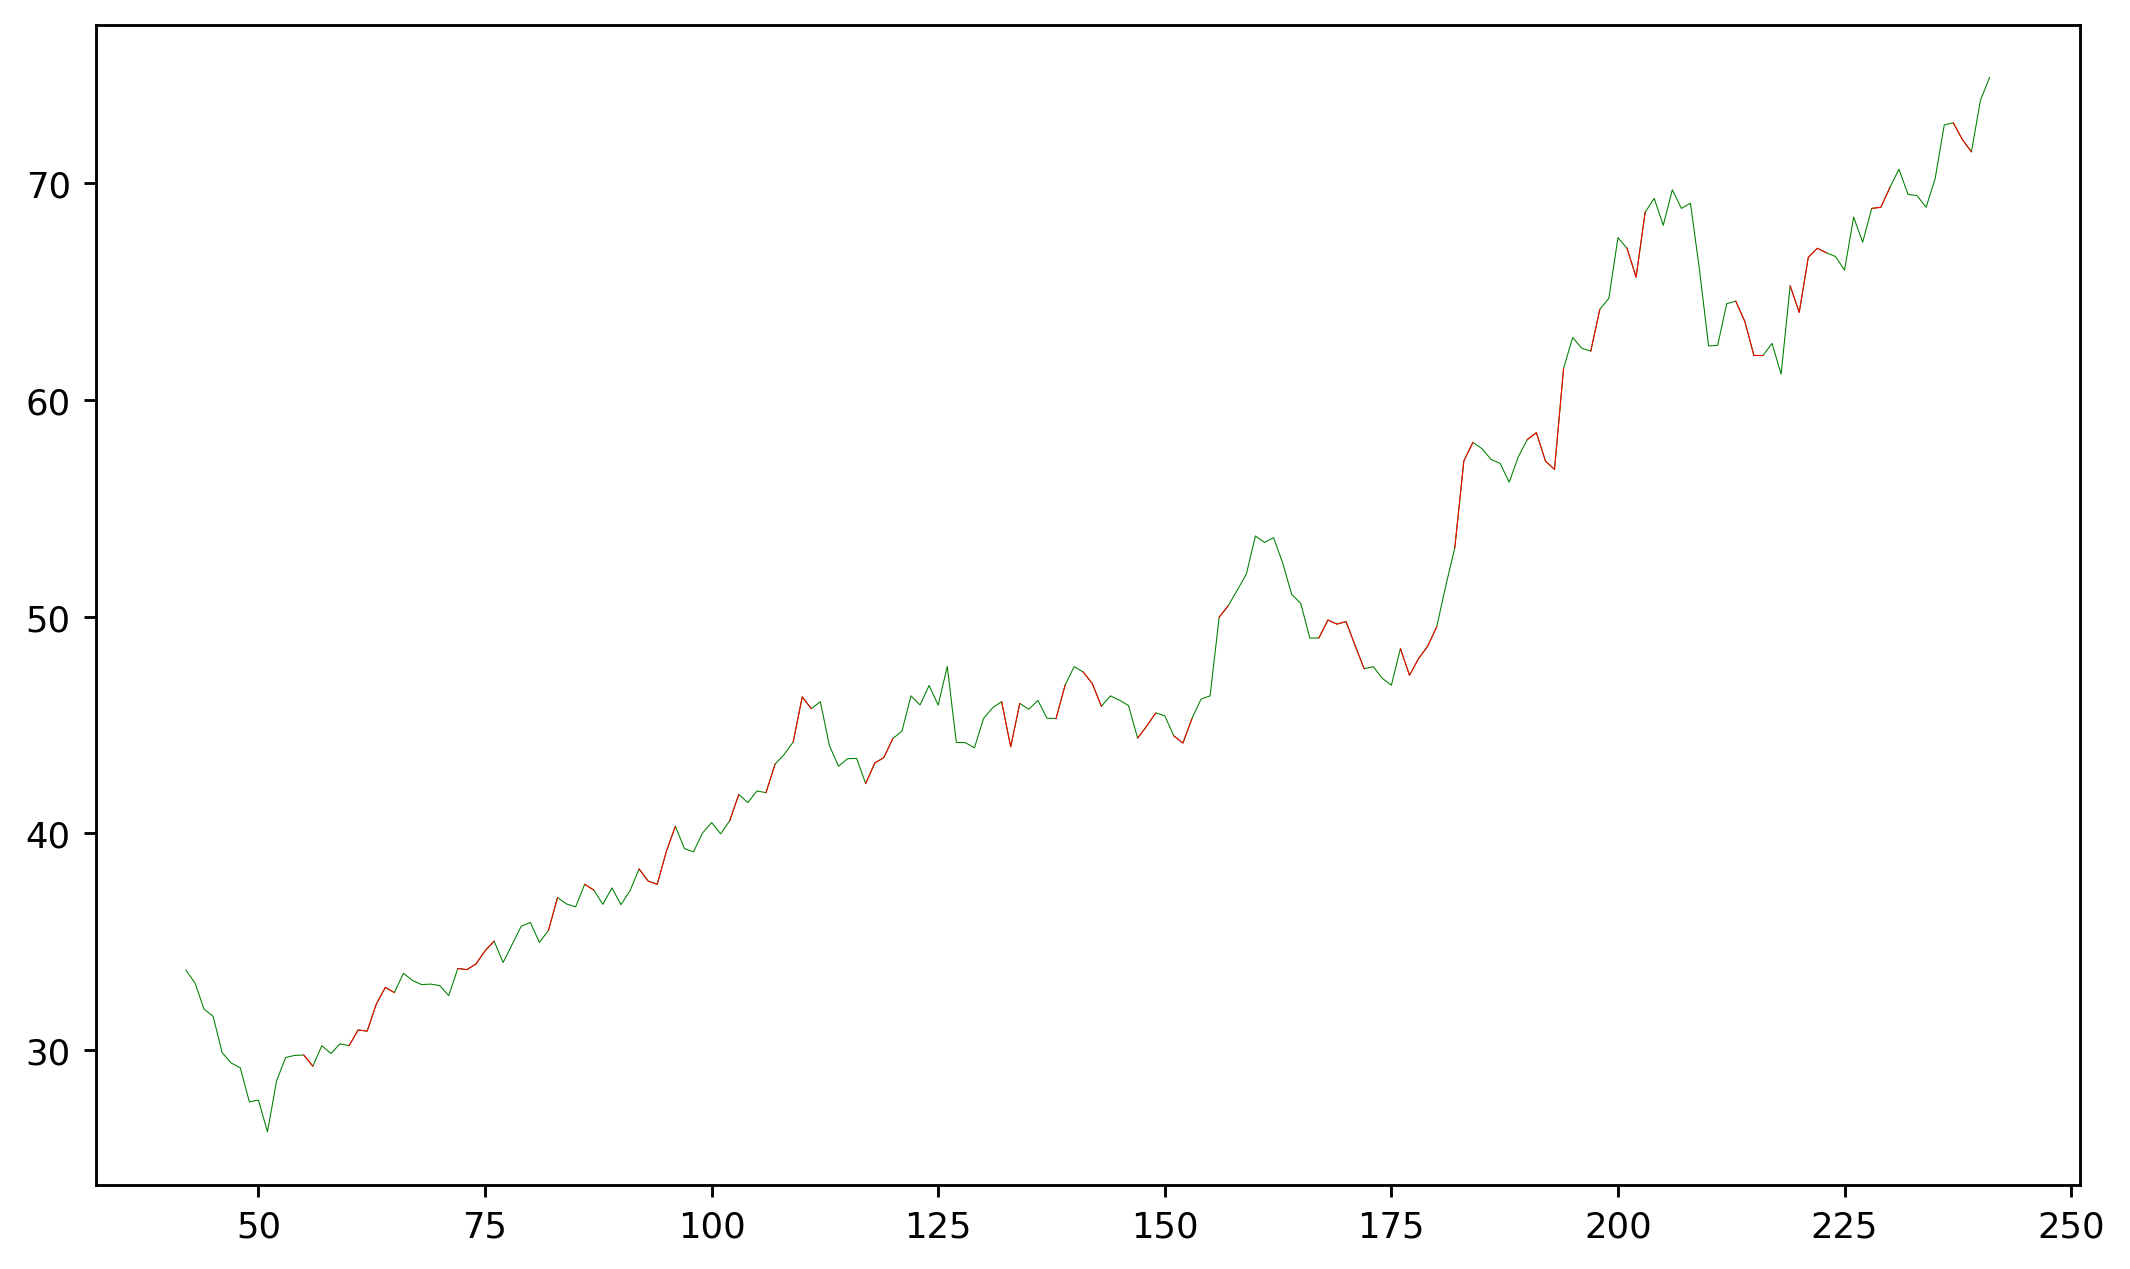

In [5]:
plt.figure(figsize=(10,6), dpi=256)
#plt.axhline(0, linewidth=0.6, linestyle='--', color='red') 
#plt.axvline(0, linestyle='--', color='red'

#plt.plot(returns, color="blue",  linewidth=0.2, linestyle="-")

plt.plot(data['close'], color="green", linewidth=0.3, linestyle="-")
plt.plot(data['res'], color = "red",  linewidth=0.3, linestyle="-")
#plt.plot(data['s_ssa'], color="blue",  linewidth=0.2, linestyle="-")
